Evaluación de m:


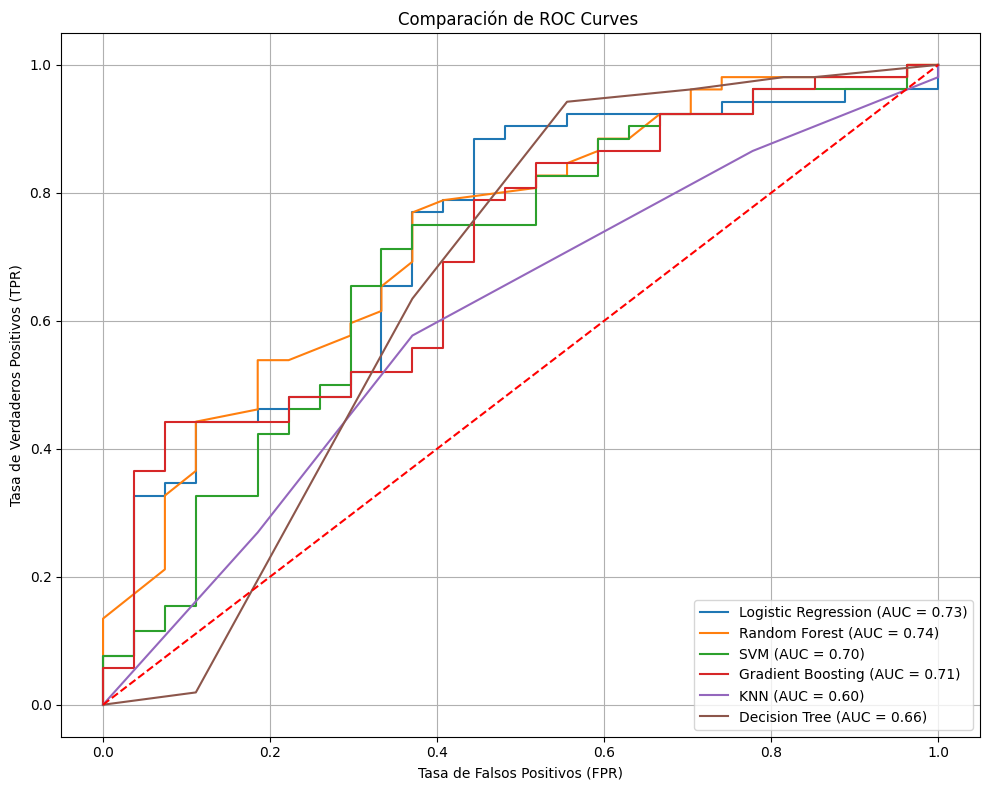

Evaluación con datos transformados (PowerTransformer):


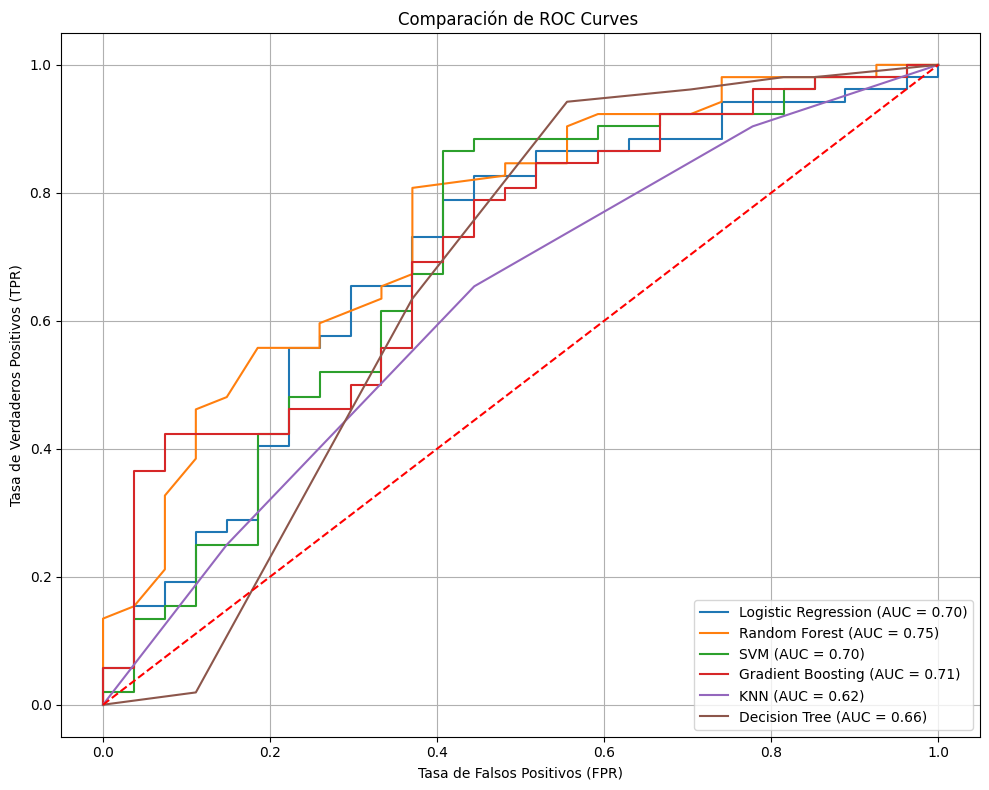

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importar datos
df = pd.read_csv('student-mat.csv')

# 2. Preprocesamiento de datos
# Codificar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separar variables predictoras y objetivo (binarización de G3)
X = df.drop(['G3', 'G2', 'G1'], axis=1)
y = (df['G3'] >= 10).astype(int)  # 1: Aprobado, 0: Suspenso

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PowerTransformer para comparar después
pt = PowerTransformer(method='yeo-johnson')
X_train_pt = pt.fit_transform(X_train)
X_test_pt = pt.transform(X_test)

# 3. Definición de modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

# 4. Función para evaluación con ROC Curve
def evaluate_models_with_roc(models, X_train, y_train, X_test, y_test, title_suffix=''):
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Entrenamiento del modelo
        model.fit(X_train, y_train)
        
        # Probabilidades para la clase positiva
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
        
        # Calcular ROC Curve y AUC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        # Graficar la ROC Curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    
    # Personalización del gráfico
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea aleatoria
    plt.title(f'Comparación de ROC Curves ')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

# 5. Evaluación con y sin PowerTransformer
print("Evaluación de m:")
evaluate_models_with_roc(models, X_train_scaled, y_train, X_test_scaled, y_test, title_suffix="(StandardScaler)")

print("Evaluación con datos transformados (PowerTransformer):")
evaluate_models_with_roc(models, X_train_pt, y_train, X_test_pt, y_test, title_suffix="(PowerTransformer)")


<class 'pandas.core.frame.DataFrame'>
Index: 357 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      357 non-null    object
 1   sex         357 non-null    object
 2   age         357 non-null    int64 
 3   address     357 non-null    object
 4   famsize     357 non-null    object
 5   Pstatus     357 non-null    object
 6   Medu        357 non-null    int64 
 7   Fedu        357 non-null    int64 
 8   Mjob        357 non-null    object
 9   Fjob        357 non-null    object
 10  reason      357 non-null    object
 11  guardian    357 non-null    object
 12  traveltime  357 non-null    int64 
 13  studytime   357 non-null    int64 
 14  failures    357 non-null    int64 
 15  schoolsup   357 non-null    object
 16  famsup      357 non-null    object
 17  paid        357 non-null    object
 18  activities  357 non-null    object
 19  nursery     357 non-null    object
 20  higher      357

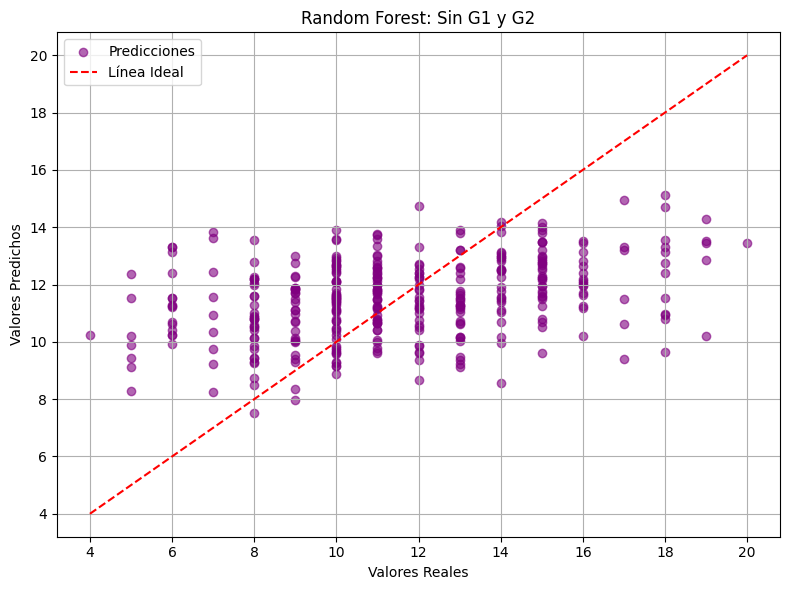

Random Forest: Con G1
MAE: 1.2807, R²: 0.7658



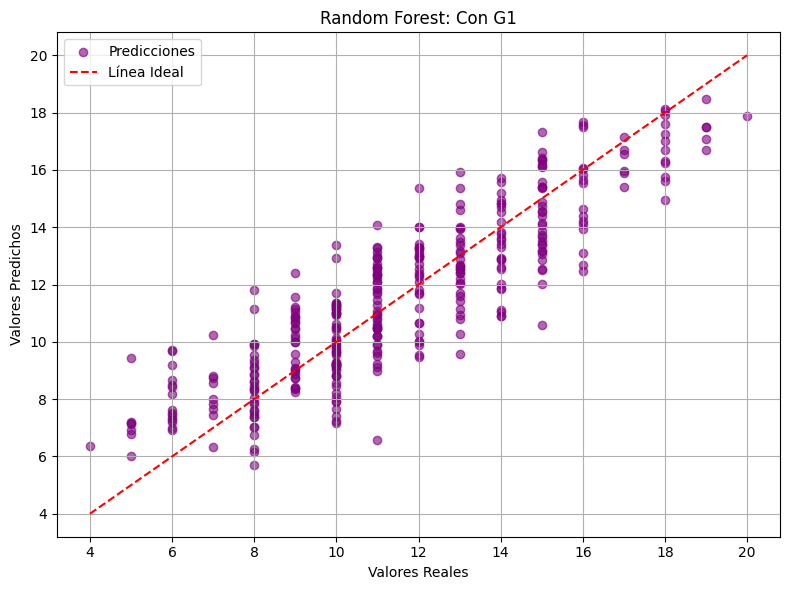

Random Forest: Con G1 y G2
MAE: 0.6922, R²: 0.9233



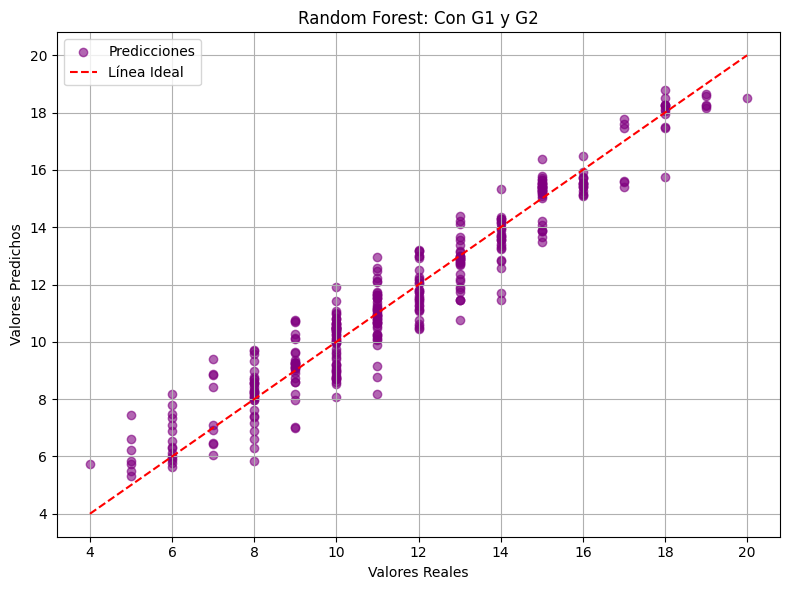

In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# Cargar el archivo filtrado
df = pd.read_csv('student-mat.csv')

df = df[df['G3'] != 0]

# Información del dataset
df.info()

# Diccionario para mapear valores categóricos binarios
bin_map = {
    'yes': 1, 'no': 0,
    'GP': 1, 'MS': 0,
    'F': 1, 'M': 0,
    'U': 1, 'R': 0,
    'LE3': 0, 'GT3': 1,
    'T': 1, 'A': 0
}

# Lista de columnas categóricas binarias
cat_cols = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
            'higher', 'internet', 'romantic']

# Aplicar mapeo binario solo a columnas con valores válidos
for col in cat_cols:
    if col in df.columns:
        unique_vals = df[col].unique()
        if all(val in bin_map for val in unique_vals):
            df[col] = df[col].map(bin_map)
        else:
            print(f"Columna {col} contiene valores no mapeados: {unique_vals}")

# Codificar columnas categóricas con más de dos valores
multi_cat_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']
label_encoders = {}
for col in multi_cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Verificar valores únicos en cada columna categórica procesada
for col in cat_cols + multi_cat_cols:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")

# Limpieza de columnas categóricas restantes
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace("'", "").str.strip()

# Definir los tres escenarios
# 1. Sin G1 y G2
X_no_g1g2 = df.drop(['G1', 'G2', 'G3'], axis=1)
y_no_g1g2 = df['G3']

# 2. Con G1 (sin G2)
X_with_g1 = df.drop(['G2', 'G3'], axis=1)
y_with_g1 = df['G3']

# 3. Con G1 y G2
X_with_g1g2 = df.drop(['G3'], axis=1)
y_with_g1g2 = df['G3']

# Función para entrenar Random Forest y graficar resultados
def train_and_plot_rf(X, y, title):
    # Escalar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Validación cruzada
    model = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42)
    y_pred_cv = cross_val_predict(model, X_scaled, y, cv=5)
    
    # Calcular métricas
    mae = mean_absolute_error(y, y_pred_cv)
    r2 = r2_score(y, y_pred_cv)
    
    print(f"{title}\nMAE: {mae:.4f}, R²: {r2:.4f}\n")
    
    # Graficar resultados
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred_cv, alpha=0.6, color='purple', label='Predicciones')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Línea Ideal')
    plt.title(title)
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Predichos')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Comparación de los tres escenarios
print("Comparación de Random Forest en diferentes escenarios:\n")

# Escenario 1: Sin G1 y G2
train_and_plot_rf(X_no_g1g2, y_no_g1g2, "Random Forest: Sin G1 y G2")

# Escenario 2: Con G1
train_and_plot_rf(X_with_g1, y_with_g1, "Random Forest: Con G1")

# Escenario 3: Con G1 y G2
train_and_plot_rf(X_with_g1g2, y_with_g1g2, "Random Forest: Con G1 y G2")


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Cargar el archivo original
df = pd.read_csv('student-mat.csv')

# Crear una copia y eliminar las filas donde G3 es 0
df_filtered = df[df['G3'] != 0]

# Aplicar One-Hot Encoding a las columnas categóricas
categorical_columns = df_filtered.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df_filtered, columns=categorical_columns, drop_first=True)

# Definir los tres escenarios
# 1. Sin G1 y G2
X_no_g1g2 = df_encoded.drop(['G1', 'G2', 'G3'], axis=1)
y_no_g1g2 = df_encoded['G3']

# 2. Con G1 (sin G2)
X_with_g1 = df_encoded.drop(['G2', 'G3'], axis=1)
y_with_g1 = df_encoded['G3']

# 3. Con G1 y G2
X_with_g1g2 = df_encoded.drop(['G3'], axis=1)
y_with_g1g2 = df_encoded['G3']

# Función para entrenar Random Forest y graficar resultados
def train_and_plot_rf(X, y, title):
    # Escalar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Validación cruzada
    model = RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42)
    y_pred_cv = cross_val_predict(model, X_scaled, y, cv=5)
    
    # Calcular métricas
    mae = mean_absolute_error(y, y_pred_cv)
    r2 = r2_score(y, y_pred_cv)
    
    print(f"{title}\nMAE: {mae:.4f}, R²: {r2:.4f}\n")
    
    # Graficar resultados
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred_cv, alpha=0.6, color='blue', label='Predicciones')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Línea Ideal')
    plt.title(title)
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Predichos')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Comparación de los tres escenarios
print("Comparación de Random Forest en diferentes escenarios:\n")

# Escenario 1: Sin G1 y G2
train_and_plot_rf(X_no_g1g2, y_no_g1g2, "Random Forest: Sin G1 y G2")

# Escenario 2: Con G1
train_and_plot_rf(X_with_g1, y_with_g1, "Random Forest: Con G1")

# Escenario 3: Con G1 y G2
train_and_plot_rf(X_with_g1g2, y_with_g1g2, "Random Forest: Con G1 y G2")


KeyError: "['G1'] not found in axis"